# YouTube Scraper

In [1]:
# !pip install google-api-python-client

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os

In [3]:
api_key = ''
channel_id = 'UCALu7ilve5NYtRpEL4lQezA'
# https://commentpicker.com/youtube-channel-id.php

# RANDOM CHANNELS
channel_ids = ['UCnz-ZXXER4jOvuED5trXfEA', # techTFQ
               'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse
               'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
               'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
               'UC2UXDak6o7rBm23k3Vv5dww' # Tina Huang
              ]

youtube = build('youtube', 'v3', developerKey = api_key)

## Function to get Thumbnails

In [4]:
def download_thumbnail(url, path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(path, 'wb') as file:
            file.write(response.content)

def get_latest_videos(channel_id, max_results=50):
    if not os.path.exists('thumbnails'):
        os.makedirs('thumbnails')

    request = youtube.search().list(
        part="snippet",
        channelId=channel_id,
        maxResults=max_results,
        order="date"
    )
    response = request.execute()

    video_number = 1

    for item in response.get("items", []):
        video_id = item.get("id", {}).get("videoId", "")
        thumbnails = item.get("snippet", {}).get("thumbnails", {})
        title = item.get("snippet", {}).get("title", "")

        if "high" in thumbnails:
            high_quality_thumbnail = thumbnails["high"]
            url = high_quality_thumbnail["url"]
            path = f"thumbnails/{video_number}_high.jpg"
            download_thumbnail(url, path)
            print(f"Downloaded high quality thumbnail for '{title}' to {path}")
            video_number += 1

In [5]:
# RUN THIS TO CREATE FOLDER WITH THUMBNAILS
# get_latest_videos(channel_id)

In [6]:
# import shutil

# # DELETING DIRECTORY
# if os.path.exists('thumbnails'):
#     shutil.rmtree('thumbnails')
#     print(f"The directory '{'thumbnails'}' has been deleted.")

## Function to Get Channel Statistics

In [7]:
def get_channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part = 'snippet,contentDetails,statistics',
        id = channel_id)
    response = request.execute()

    data = dict(Channel_name = response['items'][0]['snippet']['title'],
                Subscribers = response['items'][0]['statistics']['subscriberCount'],
                Views = response['items'][0]['statistics']['viewCount'],
                Total_videos = response['items'][0]['statistics']['videoCount'],
                playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads'])

    return data

In [8]:
get_channel_stats(youtube, channel_id)

{'Channel_name': 'SunCast Media',
 'Subscribers': '1590',
 'Views': '99479',
 'Total_videos': '193',
 'playlist_id': 'UUALu7ilve5NYtRpEL4lQezA'}

In [9]:
## FOR MULTIPLE CHANNELS

def get_channels_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)

    return all_data

In [10]:
channel_statistics = get_channel_stats(youtube, channel_id) # change to channel_ids for multiple channels

channel_data = pd.DataFrame(channel_statistics, index = [0]) # remove index for multiple channels
channel_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,SunCast Media,1590,99479,193,UUALu7ilve5NYtRpEL4lQezA


In [11]:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])
channel_data.dtypes

Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

In [12]:
# sns.set(rc={'figure.figsize':(10,8)})
# ax = sns.barplot(x='Channel_name', y='Subscribers', data=channel_data)

In [13]:
# ax = sns.barplot(x='Channel_name', y='Views', data=channel_data)

In [14]:
# ax = sns.barplot(x='Channel_name', y='Total_videos', data=channel_data)

## Function to Get Video IDs

In [15]:
playlist_id = channel_data.loc[channel_data['Channel_name']=='SunCast Media', 'playlist_id'].iloc[0]

In [16]:
def get_video_ids(youtube, playlist_id):

    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()

    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')

    return video_ids

In [17]:
video_ids = get_video_ids(youtube, playlist_id)
# video_ids

## Function to Get Video Details

In [18]:
def get_video_details(youtube, video_ids):
    all_video_stats = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part='snippet,statistics',
                    id=','.join(video_ids[i:i+50]))
        response = request.execute()

        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount']
                               )
            all_video_stats.append(video_stats)

    return all_video_stats

In [19]:
video_details = get_video_details(youtube, video_ids)

video_data = pd.DataFrame(video_details)

In [20]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data

,Title,Published_date,Views,Likes,Comments
0,Is Hydrogen a Viable Option for American Energ...,2024-04-16,530,7,0
1,Why New York Is Building Hydrogen Infrastructu...,2024-04-16,54,5,0
2,Storing Solar Energy to Sell Later ☀️💸,2024-04-11,2290,21,0
3,Adding Storage to Solar is Harder Than We Thou...,2024-04-11,184,8,0
4,How Battery Storage Will Assist the American E...,2024-04-09,460,7,1
...,...,...,...,...,...
190,"226 - Breakthrough Lithium Extraction, EnergyX...",2020-02-06,503,15,0
191,211 - Founder story of Shoals Technologies w/D...,2020-01-02,278,3,0
192,SPI Day 3 - Live from the Podcast Lounge,2019-09-27,251,5,1
193,SPI Day 2 - Live from the Suncast Podcast Lounge,2019-09-26,136,4,0


In [21]:
titles_list = video_data['Title'].tolist()
# print(titles_list)

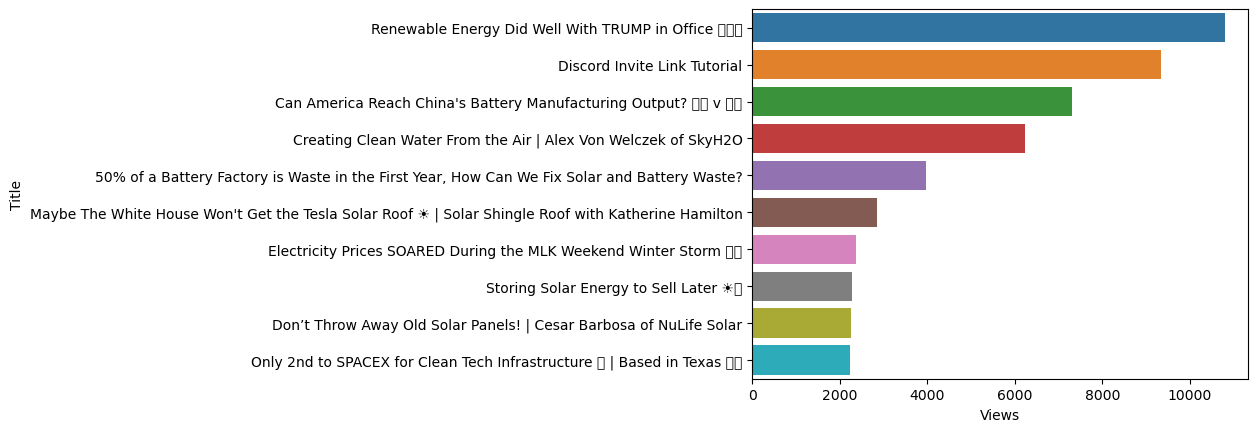

In [22]:
import warnings
warnings.filterwarnings("ignore")

top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)
top10_videos

ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

In [23]:
video_data

,Title,Published_date,Views,Likes,Comments
0,Is Hydrogen a Viable Option for American Energ...,2024-04-16,530,7,0
1,Why New York Is Building Hydrogen Infrastructu...,2024-04-16,54,5,0
2,Storing Solar Energy to Sell Later ☀️💸,2024-04-11,2290,21,0
3,Adding Storage to Solar is Harder Than We Thou...,2024-04-11,184,8,0
4,How Battery Storage Will Assist the American E...,2024-04-09,460,7,1
...,...,...,...,...,...
190,"226 - Breakthrough Lithium Extraction, EnergyX...",2020-02-06,503,15,0
191,211 - Founder story of Shoals Technologies w/D...,2020-01-02,278,3,0
192,SPI Day 3 - Live from the Podcast Lounge,2019-09-27,251,5,1
193,SPI Day 2 - Live from the Suncast Podcast Lounge,2019-09-26,136,4,0


In [24]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')
video_data

,Title,Published_date,Views,Likes,Comments,Month
0,Is Hydrogen a Viable Option for American Energ...,2024-04-16,530,7,0,Apr
1,Why New York Is Building Hydrogen Infrastructu...,2024-04-16,54,5,0,Apr
2,Storing Solar Energy to Sell Later ☀️💸,2024-04-11,2290,21,0,Apr
3,Adding Storage to Solar is Harder Than We Thou...,2024-04-11,184,8,0,Apr
4,How Battery Storage Will Assist the American E...,2024-04-09,460,7,1,Apr
...,...,...,...,...,...,...
190,"226 - Breakthrough Lithium Extraction, EnergyX...",2020-02-06,503,15,0,Feb
191,211 - Founder story of Shoals Technologies w/D...,2020-01-02,278,3,0,Jan
192,SPI Day 3 - Live from the Podcast Lounge,2019-09-27,251,5,1,Sep
193,SPI Day 2 - Live from the Suncast Podcast Lounge,2019-09-26,136,4,0,Sep


In [25]:
videos_per_month = video_data.groupby('Month', as_index=False).size()
videos_per_month

,Month,size
0,Apr,26
1,Aug,2
2,Dec,27
3,Feb,17
4,Jan,15
5,Jul,4
6,Jun,4
7,Mar,24
8,May,13
9,Nov,20


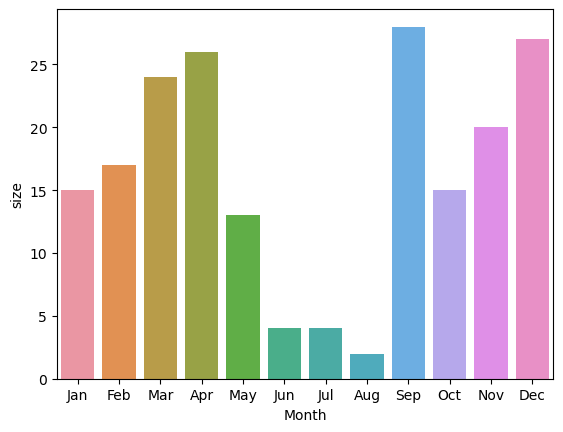

In [26]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

videos_per_month = videos_per_month.sort_index()

ax2 = sns.barplot(x='Month', y='size', data=videos_per_month)

In [27]:
# video_data.to_csv('Video_Details.csv')

## Keyword Analysis

In [28]:
from collections import defaultdict
import re
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

def extract_keywords(title):
    title = re.sub(r'[^\w\s]', '', title) # remove punctuation
    words = title.lower().split()

    stop_words = set(stopwords.words('english')) # words like the, a, etc.
    keywords = [word for word in words if word not in stop_words and not any(char.isdigit() for char in word)]

    return keywords

In [29]:
keyword_metrics = defaultdict(lambda: {'views': 0, 'likes': 0, 'comments': 0, 'num_videos': 0})

for index, row in video_data.iterrows():
    title = row['Title']
    views = row['Views']
    likes = row['Likes']
    comments = int(row['Comments'])

    keywords = extract_keywords(title)

    for keyword in keywords:
        keyword_metrics[keyword]['views'] += views
        keyword_metrics[keyword]['likes'] += likes
        keyword_metrics[keyword]['comments'] += comments
        keyword_metrics[keyword]['num_videos'] += 1

keywords = pd.DataFrame.from_dict(keyword_metrics, orient='index')

keywords['avg_views'] = keywords['views'] / keywords['num_videos']
keywords['avg_likes'] = keywords['likes'] / keywords['num_videos']
keywords['avg_comments'] = keywords['comments'] / keywords['num_videos']

keywords = keywords.sort_values(by=['avg_views', 'avg_likes', 'avg_comments'], ascending=False)
keywords_sum = keywords.sort_values(by=['views', 'likes', 'comments'], ascending=False)

keywords
keywords_sum

,views,likes,comments,num_videos,avg_views,avg_likes,avg_comments
solar,35012,1144,87,60,583.533333,19.066667,1.450000
energy,29919,1098,86,58,515.844828,18.931034,1.482759
battery,19953,168,13,8,2494.125000,21.000000,1.625000
renewable,13781,259,38,12,1148.416667,21.583333,3.166667
clean,11861,255,2,17,697.705882,15.000000,0.117647
...,...,...,...,...,...,...,...
hires,4,0,0,1,4.000000,0.000000,0.000000
stream,4,0,0,1,4.000000,0.000000,0.000000
belizaire,0,0,0,1,0.000000,0.000000,0.000000
produced,0,0,0,1,0.000000,0.000000,0.000000


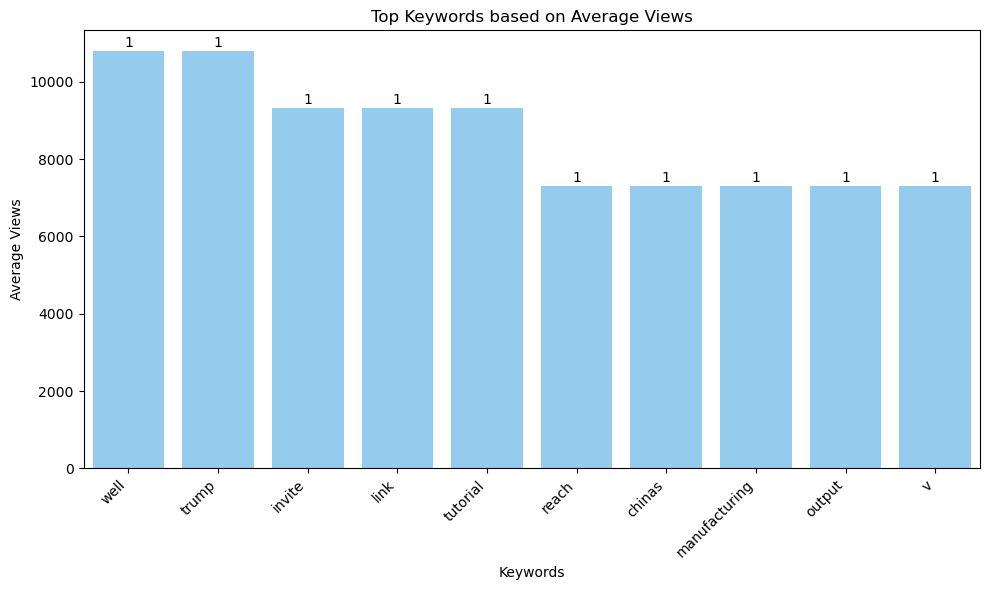

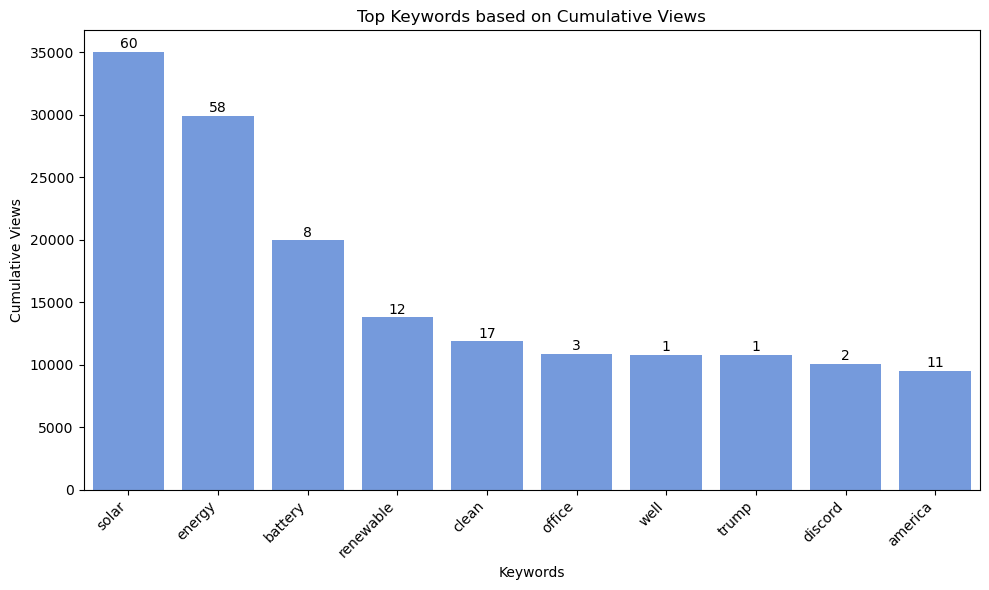

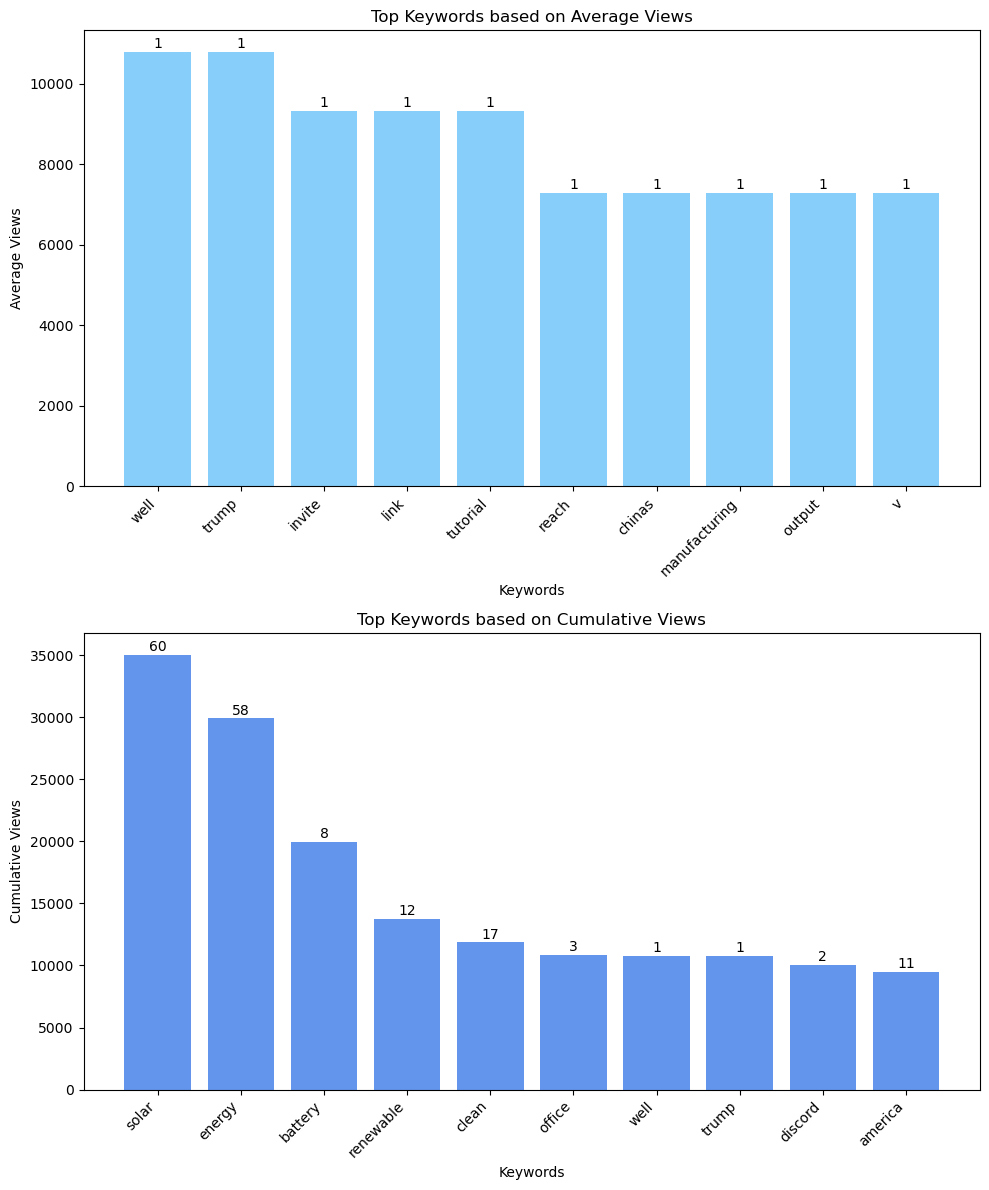

In [30]:
# Create the first plot for Average Views
plt.figure(figsize=(10, 6))
sns.barplot(x=keywords.head(10).index, y=keywords.head(10)['avg_views'], color='lightskyblue')
plt.title('Top Keywords based on Average Views')
plt.xlabel('Keywords')
plt.ylabel('Average Views')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(keywords.head(10)['num_videos']):
    plt.text(i, keywords.head(10)['avg_views'].iloc[i] + 100, value, color='black', ha='center')
plt.tight_layout()
average_views_plot = plt.gca()  # Store the first plot

# Create the second plot for Cumulative Views
plt.figure(figsize=(10, 6))
sns.barplot(x=keywords_sum.head(10).index, y=keywords_sum.head(10)['views'], color='cornflowerblue')
plt.title('Top Keywords based on Cumulative Views')
plt.xlabel('Keywords')
plt.ylabel('Cumulative Views')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(keywords_sum.head(10)['num_videos']):
    plt.text(i, keywords_sum.head(10)['views'].iloc[i] + 300, value, color='black', ha='center')
plt.tight_layout()
cumulative_views_plot = plt.gca()  # Store the second plot

# Display the plots vertically
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Changed from (1, 2) to (2, 1)

# Add the first plot to the first subplot
plt.sca(axes[0])
plt.title('Top Keywords based on Average Views')
plt.xlabel('Keywords')
plt.ylabel('Average Views')
plt.xticks(rotation=45, ha='right')
plt.bar(keywords.head(10).index, keywords.head(10)['avg_views'], color='lightskyblue')
for i, value in enumerate(keywords.head(10)['num_videos']):
    plt.text(i, keywords.head(10)['avg_views'].iloc[i] + 100, value, color='black', ha='center')

# Add the second plot to the second subplot
plt.sca(axes[1])
plt.title('Top Keywords based on Cumulative Views')
plt.xlabel('Keywords')
plt.ylabel('Cumulative Views')
plt.xticks(rotation=45, ha='right')
plt.bar(keywords_sum.head(10).index, keywords_sum.head(10)['views'], color='cornflowerblue')
for i, value in enumerate(keywords_sum.head(10)['num_videos']):
    plt.text(i, keywords_sum.head(10)['views'].iloc[i] + 300, value, color='black', ha='center')

plt.tight_layout()

# Save the figure
plt.savefig('combined_plots_vertical.png')

plt.show()

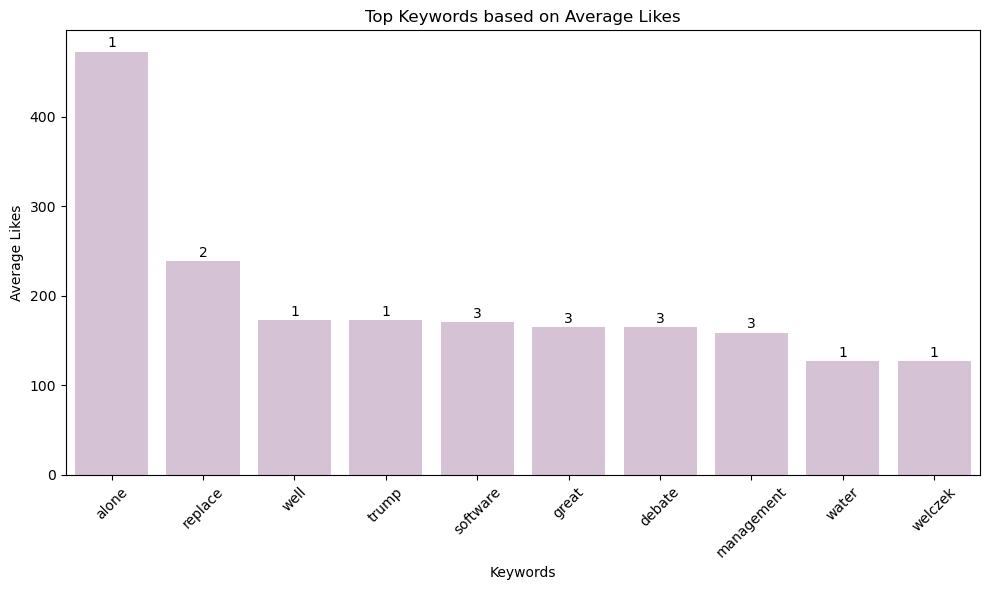

In [42]:
# Average Likes
plt.figure(figsize=(10, 6))
likes_sorted_keywords = keywords.sort_values(by='avg_likes', ascending=False).head(10)
sns.barplot(x=likes_sorted_keywords.index, y=likes_sorted_keywords['avg_likes'], color = 'thistle')
plt.title('Top Keywords based on Average Likes')
plt.xlabel('Keywords')
plt.ylabel('Average Likes')
plt.xticks(rotation=45)
for i, value in enumerate(likes_sorted_keywords['num_videos']):
    plt.text(i, likes_sorted_keywords['avg_likes'].iloc[i] + 5, value,
             color='black', ha='center')
plt.tight_layout()
# plt.savefig('avg_likes')
plt.show()

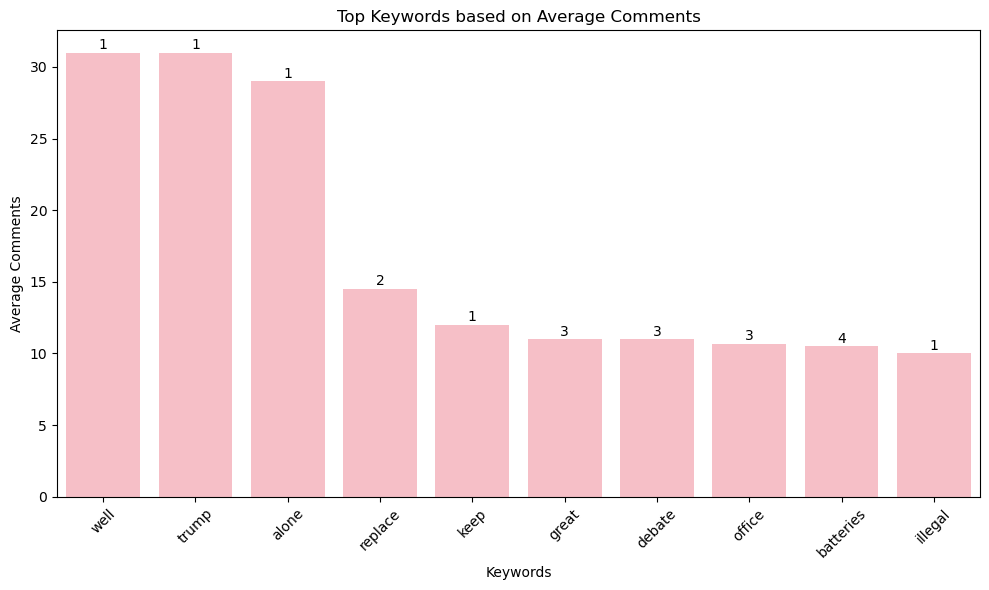

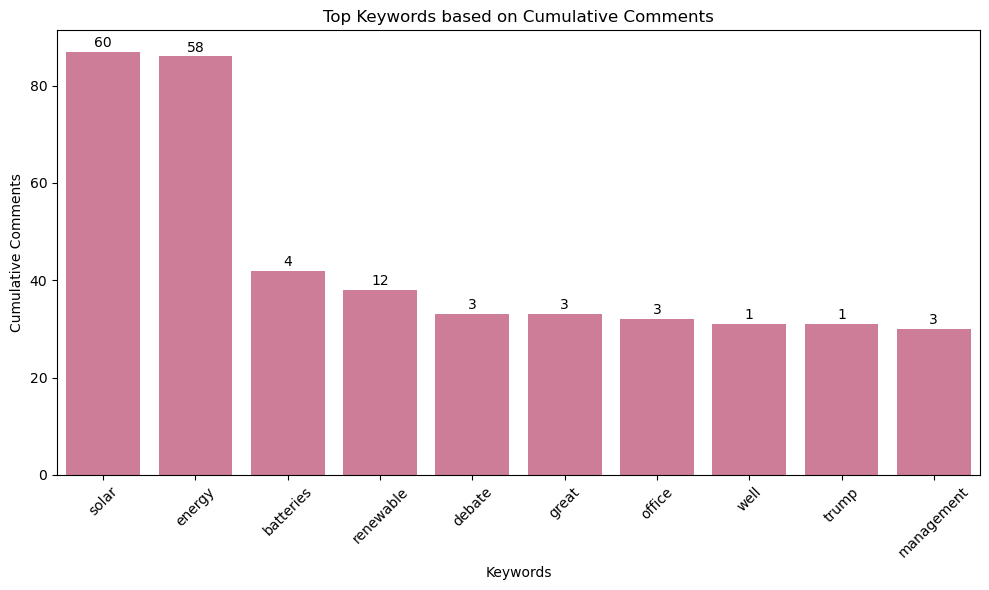

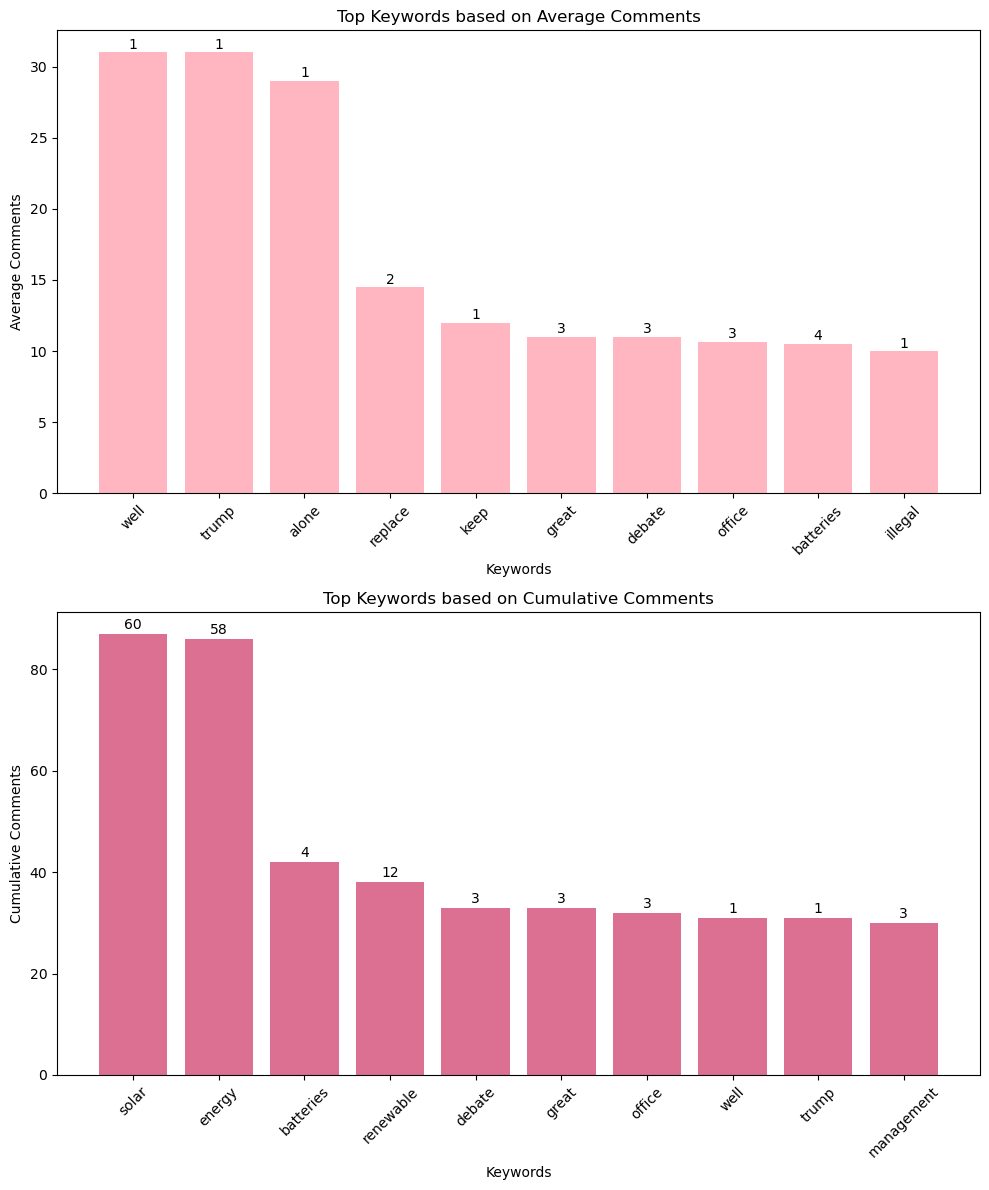

In [39]:
# Average Comments
plt.figure(figsize=(10, 6))
comments_sorted_keywords_avg = keywords.sort_values(by='avg_comments', ascending=False).head(10)
sns.barplot(x=comments_sorted_keywords_avg.index, y=comments_sorted_keywords_avg['avg_comments'], color='lightpink')
plt.title('Top Keywords based on Average Comments')
plt.xlabel('Keywords')
plt.ylabel('Average Comments')
plt.xticks(rotation=45)
for i, value in enumerate(comments_sorted_keywords_avg['num_videos']):
    plt.text(i, comments_sorted_keywords_avg['avg_comments'].iloc[i] + 0.25, value,
             color='black', ha='center')
plt.tight_layout()
average_comments_plot = plt.gca()  # Store the plot for average comments

# Cumulative Comments
plt.figure(figsize=(10, 6))
comments_sorted_keywords_sum = keywords_sum.sort_values(by='comments', ascending=False).head(10)
sns.barplot(x=comments_sorted_keywords_sum.index, y=comments_sorted_keywords_sum['comments'], color='palevioletred')
plt.title('Top Keywords based on Cumulative Comments')
plt.xlabel('Keywords')
plt.ylabel('Cumulative Comments')
plt.xticks(rotation=45)
for i, value in enumerate(comments_sorted_keywords_sum['num_videos']):
    plt.text(i, comments_sorted_keywords_sum['comments'].iloc[i] + 1, value,
             color='black', ha='center')
plt.tight_layout()
cumulative_comments_plot = plt.gca()  # Store the plot for cumulative comments

# Display the plots vertically
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Add the plot for Average Comments to the first subplot
plt.sca(axes[0])
plt.title('Top Keywords based on Average Comments')
plt.xlabel('Keywords')
plt.ylabel('Average Comments')
plt.xticks(rotation=45)
plt.bar(comments_sorted_keywords_avg.index, comments_sorted_keywords_avg['avg_comments'], color='lightpink')
for i, value in enumerate(comments_sorted_keywords_avg['num_videos']):
    plt.text(i, comments_sorted_keywords_avg['avg_comments'].iloc[i] + 0.25, value, color='black', ha='center')

# Add the plot for Cumulative Comments to the second subplot
plt.sca(axes[1])
plt.title('Top Keywords based on Cumulative Comments')
plt.xlabel('Keywords')
plt.ylabel('Cumulative Comments')
plt.xticks(rotation=45)
plt.bar(comments_sorted_keywords_sum.index, comments_sorted_keywords_sum['comments'], color='palevioletred')
for i, value in enumerate(comments_sorted_keywords_sum['num_videos']):
    plt.text(i, comments_sorted_keywords_sum['comments'].iloc[i] + 1, value, color='black', ha='center')

plt.tight_layout()

# Save the figure
plt.savefig('combined_plots_vertical.png')

plt.show()

In [35]:
# keywords_sum.to_csv('Youtube_Keywords_sum.csv')
# keywords.to_csv('YouTube_Keywords_avg.csv')